# Task: People Detection & Counting

## Requirements

In [1]:
# prompt: connect with kaggle

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d tthien/shanghaitech

Dataset URL: https://www.kaggle.com/datasets/tthien/shanghaitech
License(s): unknown
 97%|███████████████████████████████████████▊ | 323M/333M [00:01<00:00, 194MB/s]
100%|█████████████████████████████████████████| 333M/333M [00:01<00:00, 177MB/s]


In [3]:
# prompt: unzip

!unzip /content/shanghaitech.zip


unzip:  cannot find or open /content/shanghaitech.zip, /content/shanghaitech.zip.zip or /content/shanghaitech.zip.ZIP.


In [4]:
#image augmentation
!pip install albumentations==1.1.0

In [5]:
#to show loss graph
!pip install livelossplot==0.5.4

In [6]:
!pip install pytorch_lightning

In [7]:
import random
from copy import deepcopy
from multiprocessing import Pool
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import albumentations as albu
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from livelossplot import PlotLosses
from PIL import Image
from pytorch_lightning import Callback, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import Tensor
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanAbsoluteError
from torchvision import models, transforms
import warnings
warnings.filterwarnings('ignore')

## Task description

The task of people counting (or crowd counting) is about estimating the number of people present in the given image. In real life this is being used in surveillance and traffic control systems.

There are several different public data sets created by researchers for experimentation and evaluation of different methods for crowd counting. In the scope of the received task JHU-CROWD++ (v2.0) data set [1] was considered for model training and performance evaluation.


## Constants

In [8]:

CACHE_ROOT = Path("./cache") # Directory to cache generated density map
MODEL_SAVE_PATH = "./model.pt"
CHECKPOINTS_DIR = "./checkpoints"
SEED = 42

## Utility functions

Below several usefull utility functions are defined which are used throughout the notebook.

In [9]:
def load_dataset_paths(dataset_root: Path, img_extensions: set) -> List[Tuple[Path, Path]]:
    images_path = dataset_root / "images"
    gt_path = dataset_root / "gt"

    img_paths = [p for p in images_path.iterdir() if p.suffix in img_extensions]
    gt_paths = [gt_path / f"{img_path.stem}.txt" for img_path in img_paths]
    return list(zip(img_paths, gt_paths))


def load_gt(path: Path) -> np.ndarray:
    with path.open("r") as f:
        gt = [list(map(int, line.rstrip().split())) for line in f]
    #assert all([len(target) == 6 for target in gt]), f"Wrong target format {path}"
    return np.array(gt, dtype=np.int32)


def load_image(img_path: Union[Path, str]) -> Image.Image:
    return Image.open(img_path).convert("RGB")


def draw_gt_labels(img: np.ndarray, gt_labels: np.ndarray) -> None:
    img = np.array(img)
    for gt_label in gt_labels:
        keypoint = gt_label[:2]
        #xy_min = keypoint - gt_label[2:4]
        #xy_max = keypoint + gt_label[2:4]

        img = cv2.circle(img, tuple(keypoint), 4, (255, 0, 0), -1)
        #img = cv2.rectangle(img, tuple(xy_min), tuple(xy_max), (0, 255, 0))
    return img

# reverse
def gauss2D(shape: Tuple[int, int], sigma: float = 0.5) -> np.ndarray:
    my, mx = [(x - 1) / 2 for x in shape]
    y, x = np.ogrid[-my:my + 1, -mx:mx + 1]
    gmap = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    normalizer = gmap.sum()
    if normalizer != 0:
        gmap /= normalizer
    return gmap


def generate_density_map(
    size: Tuple[int, int],
    keypoints: np.ndarray,
    kernel_size: int = 30,
    sigma: float = 8
) -> np.ndarray:
    w, h = size
    keypoints = keypoints.astype(np.int32)
    density_map = np.zeros((h, w), dtype=np.float32)

    for keypoint in keypoints:
        keypoint = np.clip(keypoint, a_min=1, a_max=[w, h])
        x1, y1 = np.clip(np.array(keypoint - kernel_size // 2), a_min=1, a_max=[w, h])
        x2, y2 = np.clip(np.array(keypoint + kernel_size // 2), a_min=1, a_max=[w, h])
        gmap = gauss2D((y2 - y1 + 1, x2 - x1 + 1), sigma)
        density_map[y1 - 1:y2, x1 - 1:x2] = density_map[y1 - 1:y2, x1 - 1:x2] + gmap

    return density_map


def random_crop(
    img: Image.Image,
    density_map: np.ndarray,
    input_h: int = 512,
    input_w: int = 512
) -> Tuple[Image.Image, np.ndarray]:
    img_w, img_h = img.size

    padded_img = np.zeros((input_h, input_w, 3), dtype=np.uint8)
    padded_density_map = np.zeros((input_h, input_w), dtype=np.float32)

    crop_min_x = np.random.randint(0, max(1, img_w - input_w))
    crop_min_y = np.random.randint(0, max(1, img_h - input_h))
    crop_max_x = min(crop_min_x + input_w, img_w)
    crop_max_y = min(crop_min_y + input_h, img_h)

    crop_w, crop_h = min(input_w, img_w), min(input_h, img_h)
    padded_img[:crop_h, :crop_w, :] = np.array(img)[crop_min_y:crop_max_y, crop_min_x:crop_max_x, :]
    padded_density_map[:crop_h, :crop_w] = density_map[crop_min_y:crop_max_y, crop_min_x:crop_max_x]

    return Image.fromarray(padded_img), padded_density_map


def resize_img(img: Image.Image, min_size: int = 512, max_size: int = 1536) -> Tuple[Image.Image, float]:
    resize_ratio = 1.0
    if img.size[0] > max_size or img.size[1] > max_size:
        resize_ratio = max_size / img.size[0] if img.size[0] > max_size else max_size / img.size[1]
        resized_w = int(np.ceil(img.size[0] * resize_ratio))
        resized_h = int(np.ceil(img.size[1] * resize_ratio))
        img = img.resize((resized_w, resized_h))

    if img.size[0] < min_size or img.size[1] < min_size:
        resize_ratio = min_size / img.size[0] if img.size[0] < min_size else min_size / img.size[1]
        resized_w = int(np.ceil(img.size[0] * resize_ratio))
        resized_h = int(np.ceil(img.size[1] * resize_ratio))
        img = img.resize((resized_w, resized_h))

    return img, resize_ratio


def scale_density_map(density_map: np.ndarray, scale_factor: int = 1):
    scaled_density_map = cv2.resize(
        density_map,
        (density_map.shape[1] // scale_factor, density_map.shape[0] // scale_factor),
        interpolation=cv2.INTER_CUBIC #provide smoother results
    )
    scaled_density_map *= (scale_factor ** 2) #to remains consistent and high quality it realted to colors and values
    return scaled_density_map


def preprocess_transform(
    img: Image.Image,
    mean: List[float] = [0.485, 0.456, 0.406],
    std: List[float] = [0.229, 0.224, 0.225]
) -> Tensor:
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])(img)

#using in suffling
def seed_worker(worker_id: int) -> None:
    worker_seed = torch.initial_seed() % (2**32)  # Ensure it's an integer
    random.seed(worker_seed)
    np.random.seed(worker_seed)

## Dataset

The following class provides an easy to use interface for working with JHU-CROWD++ dataset during exploratory data analysis and model training.

In [10]:
class JHUCrowdDataset(Dataset):
    img_extensions = {".jpg"}

    def __init__(
        self,
        dataset_root: Path,
        subset_name: str = "train",
        transform: Optional[Callable[[Image.Image, np.ndarray], Tuple[Tensor, np.ndarray]]] = None,
        scale_factor: int = 1,
        min_size: Optional[int] = None,
        max_size: Optional[int] = None,
        force_pregenerate: bool = False,
        num_workers: int = 8,
        min_crowd_size: int = 0,
        cache_root: Path = Path("./cache"),
        cache: bool = True
    ) -> None:
        super(JHUCrowdDataset, self).__init__()

        self.dataset_root = dataset_root
        self.subset_name = subset_name
        self.transform = transform
        self.scale_factor = scale_factor
        self.min_size = min_size
        self.max_size = max_size
        self.min_crowd_size = min_crowd_size
        self.num_workers = num_workers
        self.cache_dir = cache_root / subset_name
        self.cache = cache

        img_labels_df = self.load_img_labels(dataset_root / subset_name)
        self.img_labels_df = img_labels_df[img_labels_df["count"] >= min_crowd_size]

        if force_pregenerate and cache:
            self.pregenerate_density_maps()

    def load_img_labels(self, dataset_root: Path) -> pd.DataFrame:
        # Load image_labels.txt
        img_info_df = pd.read_csv(
            dataset_root / "image_labels.txt",
            names=["name", "count"],
            dtype={"name": str, "count": int}
        )
        img_info_df.set_index("name", inplace=True)

        # Load image & gt path combinations"
        img_gt_paths = load_dataset_paths(dataset_root, self.img_extensions)
        names = [img_path.stem for img_path, _ in img_gt_paths]

        img_gt_paths_df = pd.DataFrame(img_gt_paths, columns=["img_path", "gt_path"], index=names)
        gt_labels = pd.Series([
            load_gt(gt_path) for gt_path in img_gt_paths_df["gt_path"]], name="gt_labels", index=names)
        gt_counts = pd.Series([len(gt) for gt in gt_labels], index=names)

        # Check integrity
        assert len(img_info_df) == len(img_gt_paths)
        assert len(img_gt_paths_df.index.difference(img_info_df.index)) == 0
        assert all(img_info_df["count"].eq(gt_counts))

        return pd.concat([img_gt_paths_df, gt_labels, img_info_df], axis=1)

    #do operation in parallel to speed up computation
    def pregenerate_density_maps(self) -> None:
        with Pool(self.num_workers) as p:
            p.map(self.__getitem__, range(len(self)))

    def __getitem__(self, index: int) -> Tuple[Image.Image, np.ndarray]:
        sample = self.img_labels_df.iloc[index]

        cached_img_path = self.cache_dir / f"{sample.name}.jpg"
        cached_density_path = self.cache_dir / f"{sample.name}.npy"
        if self.cache and cached_density_path.exists() and cached_img_path.exists():
            img = load_image(cached_img_path)
            density_map = np.load(str(cached_density_path))
        else:
            img = load_image(sample["img_path"])
            keypoints = np.empty((0, 2))
            if len(sample["gt_labels"] > 0):
                keypoints = sample["gt_labels"][:, :2]

            if self.min_size is not None and self.max_size is not None:
                img, resize_ratio = resize_img(img, min_size=self.min_size, max_size=self.max_size)
                keypoints = (keypoints * resize_ratio).astype(np.int32)
            density_map = generate_density_map(img.size, keypoints)

            if self.cache:
                self.cache_dir.mkdir(parents=True, exist_ok=True)
                np.save(str(self.cache_dir / f"{sample.name}.npy"), density_map)
                img.save(str(self.cache_dir / f"{sample.name}.jpg"))

        if self.transform is not None:
            img, density_map = self.transform(img, density_map)

        density_map = scale_density_map(density_map, self.scale_factor)

        return img, density_map

    def __len__(self) -> int:
        return len(self.img_labels_df)

    @staticmethod
    def collate_fn(samples: List[Tuple[Tensor, Tensor]]) -> List[Tensor]:
        img_batch = torch.stack([sample[0] for sample in samples], 0)
        density_map_batch = torch.stack([torch.from_numpy(sample[1]).unsqueeze(0) for sample in samples], 0)
        return [img_batch, density_map_batch]

## Exploratory data analysis

In [11]:
import cv2
import albumentations as A
import numpy as np
import os

def add_rain(image):
    # Apply rain effect using Albumentations
    transform = A.Compose([
        A.RandomRain(
            p=1.0,                       # Probability of applying the effect
            rain_type='heavy',            # Increase the rain intensity to 'heavy'
            brightness_coefficient=1.0,   # Slightly reduce brightness for a more realistic effect
            drop_length=8,                # Increase rain drop length for a heavier rain effect
            drop_width=1                  # Increase drop width for thicker rain drops
        )
    ])
    augmented = transform(image=image)
    return augmented['image']

def process_images(input_folder, output_folder):
    # Check if the output folder exists, if not, create it
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all the images in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            # Construct the full image path
            image_path = os.path.join(input_folder, filename)

            # Load the image
            image = cv2.imread(image_path)

            # Optionally resize the image for better quality rain effect (increase resolution)
            height, width = image.shape[:2]
            image_resized = cv2.resize(image, (width*2, height*2), interpolation=cv2.INTER_LINEAR)

            # Add rain effect
            image_with_rain = add_rain(image_resized)

            # Optional post-processing (Sharpen the image after applying rain)
            kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
            sharpened_image = cv2.filter2D(image_with_rain, -1, kernel)

            # Resize back to original size
            final_image = cv2.resize(sharpened_image, (width, height), interpolation=cv2.INTER_LINEAR)

            # Modify the filename by adding 'train' before the extension
            #filename_base, file_extension = os.path.splitext(filename)
            #new_filename = f"{filename_base}_train{file_extension}"

            # Save the result in the output folder with the new filename
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, final_image)
            #print(f"Processed and saved: {output_path}")

# Specify the input folder and the output folder
input_folder = '/kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/images/'  # Update with your input folder path
output_folder = '/kaggle/working/part_A/Train/images/'           # Update with your output folder path

# Process all images in the folder
process_images(input_folder, output_folder)


In [12]:
import os
import scipy.io
import numpy as np

def save_mat_as_txt(mat_file_path, txt_file_path):
    # Load the .mat file
    mat_data = scipy.io.loadmat(mat_file_path)

    # Assuming 'people_array' or some key contains the people count or the data you want
    # Adjust 'image_info' to match your .mat file structure
    people_array = mat_data.get('image_info')[0][0][0][0][0]  # Based on your .mat structure

    if people_array is not None:
        # Save the people array data to a .txt file
        np.savetxt(txt_file_path, people_array, fmt='%d')  # Adjust the format as needed
        # Return the count (assuming the number of people is the first dimension)
        return people_array.shape[0]
    else:
        print(f"No 'people_array' found in {mat_file_path}")
        return 0

def process_mat_files(input_folder, output_folder):
    image_labels = []

    # Create the 'gt' folder in the output folder if it doesn't exist
    gt_folder = os.path.join(output_folder, 'gt')
    os.makedirs(gt_folder, exist_ok=True)

    # Loop through all the .mat files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".mat"):
            # Remove .mat from the filename to use it for naming
            base_filename = filename.replace('.mat', '')
            base_filename = base_filename.replace('GT_', '')  # Remove 'GT_' from the filename

            # Paths for the .mat file and the corresponding .txt file
            mat_file_path = os.path.join(input_folder, filename)

            # Create the .txt file inside the 'gt' folder with the same base filename
            txt_file_path = os.path.join(gt_folder, f"{base_filename}.txt")

            # Save .mat data to .txt and get the count
            people_count = save_mat_as_txt(mat_file_path, txt_file_path)

            # Append the image name and the people count to the image_labels list
            image_labels.append(f"{base_filename},{people_count}")

    # Save the image_labels.txt file
    image_labels_file = os.path.join(output_folder, 'image_labels.txt')
    with open(image_labels_file, 'w') as f:
        for label in image_labels:
            f.write(label + '\n')

# Example usage:
input_folder = '/kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/ground-truth'
output_folder = '/kaggle/working/part_A/Train'

# Process all .mat files and create image_labels.txt
process_mat_files(input_folder, output_folder)


In [13]:
import cv2
import albumentations as A
import numpy as np
import os

def add_rain(image):
    # Apply rain effect using Albumentations
    transform = A.Compose([
        A.RandomRain(
            p=1.0,                       # Probability of applying the effect
            rain_type='heavy',            # Increase the rain intensity to 'heavy'
            brightness_coefficient=1.0,   # Slightly reduce brightness for a more realistic effect
            drop_length=8,                # Increase rain drop length for a heavier rain effect
            drop_width=1                  # Increase drop width for thicker rain drops
        )
    ])
    augmented = transform(image=image)
    return augmented['image']

def process_images(input_folder, output_folder):
    # Check if the output folder exists, if not, create it
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all the images in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            # Construct the full image path
            image_path = os.path.join(input_folder, filename)

            # Load the image
            image = cv2.imread(image_path)

            # Optionally resize the image for better quality rain effect (increase resolution)
            height, width = image.shape[:2]
            image_resized = cv2.resize(image, (width*2, height*2), interpolation=cv2.INTER_LINEAR)

            # Add rain effect
            image_with_rain = add_rain(image_resized)

            # Optional post-processing (Sharpen the image after applying rain)
            kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
            sharpened_image = cv2.filter2D(image_with_rain, -1, kernel)

            # Resize back to original size
            final_image = cv2.resize(sharpened_image, (width, height), interpolation=cv2.INTER_LINEAR)

            # Modify the filename by adding 'train' before the extension
            #filename_base, file_extension = os.path.splitext(filename)
            #new_filename = f"{filename_base}_train{file_extension}"

            # Save the result in the output folder with the new filename
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, final_image)
            #print(f"Processed and saved: {output_path}")

# Specify the input folder and the output folder
input_folder = '/kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/images/'  # Update with your input folder path
output_folder = '/kaggle/working/part_A/Test/images/'           # Update with your output folder path

# Process all images in the folder
process_images(input_folder, output_folder)


In [14]:
import os
import scipy.io
import numpy as np

def save_mat_as_txt(mat_file_path, txt_file_path):
    # Load the .mat file
    mat_data = scipy.io.loadmat(mat_file_path)

    # Assuming 'people_array' or some key contains the people count or the data you want
    # Adjust 'image_info' to match your .mat file structure
    people_array = mat_data.get('image_info')[0][0][0][0][0]  # Based on your .mat structure

    if people_array is not None:
        # Save the people array data to a .txt file
        np.savetxt(txt_file_path, people_array, fmt='%d')  # Adjust the format as needed
        # Return the count (assuming the number of people is the first dimension)
        return people_array.shape[0]
    else:
        print(f"No 'people_array' found in {mat_file_path}")
        return 0

def process_mat_files(input_folder, output_folder):
    image_labels = []

    # Create the 'gt' folder in the output folder if it doesn't exist
    gt_folder = os.path.join(output_folder, 'gt')
    os.makedirs(gt_folder, exist_ok=True)

    # Loop through all the .mat files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".mat"):
            # Remove .mat from the filename to use it for naming
            base_filename = filename.replace('.mat', '')
            base_filename = base_filename.replace('GT_', '')  # Remove 'GT_' from the filename

            # Paths for the .mat file and the corresponding .txt file
            mat_file_path = os.path.join(input_folder, filename)

            # Create the .txt file inside the 'gt' folder with the same base filename
            txt_file_path = os.path.join(gt_folder, f"{base_filename}.txt")

            # Save .mat data to .txt and get the count
            people_count = save_mat_as_txt(mat_file_path, txt_file_path)

            # Append the image name and the people count to the image_labels list
            image_labels.append(f"{base_filename},{people_count}")

    # Save the image_labels.txt file
    image_labels_file = os.path.join(output_folder, 'image_labels.txt')
    with open(image_labels_file, 'w') as f:
        for label in image_labels:
            f.write(label + '\n')

# Example usage:
input_folder = '/kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/ground-truth'
output_folder = '/kaggle/working/part_A/Test'

# Process all .mat files and create image_labels.txt
process_mat_files(input_folder, output_folder)


In [15]:
import cv2
import albumentations as A
import numpy as np
import os

def add_rain(image):
    # Apply rain effect using Albumentations
    transform = A.Compose([
        A.RandomRain(
            p=1.0,                       # Probability of applying the effect
            rain_type='heavy',            # Increase the rain intensity to 'heavy'
            brightness_coefficient=1.0,   # Slightly reduce brightness for a more realistic effect
            drop_length=8,                # Increase rain drop length for a heavier rain effect
            drop_width=1                  # Increase drop width for thicker rain drops
        )
    ])
    augmented = transform(image=image)
    return augmented['image']

def process_images(input_folder, output_folder):
    # Check if the output folder exists, if not, create it
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all the images in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            # Construct the full image path
            image_path = os.path.join(input_folder, filename)

            # Load the image
            image = cv2.imread(image_path)

            # Optionally resize the image for better quality rain effect (increase resolution)
            height, width = image.shape[:2]
            image_resized = cv2.resize(image, (width*2, height*2), interpolation=cv2.INTER_LINEAR)

            # Add rain effect
            image_with_rain = add_rain(image_resized)

            # Optional post-processing (Sharpen the image after applying rain)
            kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
            sharpened_image = cv2.filter2D(image_with_rain, -1, kernel)

            # Resize back to original size
            final_image = cv2.resize(sharpened_image, (width, height), interpolation=cv2.INTER_LINEAR)

            # Modify the filename by adding 'train' before the extension
            #filename_base, file_extension = os.path.splitext(filename)
            #new_filename = f"{filename_base}_train{file_extension}"

            # Save the result in the output folder with the new filename
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, final_image)
            #print(f"Processed and saved: {output_path}")

# Specify the input folder and the output folder
input_folder = '/kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/images/'  # Update with your input folder path
output_folder = '/kaggle/working/part_A/Val/images/'           # Update with your output folder path

# Process all images in the folder
process_images(input_folder, output_folder)


In [16]:
import os
import scipy.io
import numpy as np

def save_mat_as_txt(mat_file_path, txt_file_path):
    # Load the .mat file
    mat_data = scipy.io.loadmat(mat_file_path)

    # Assuming 'people_array' or some key contains the people count or the data you want
    # Adjust 'image_info' to match your .mat file structure
    people_array = mat_data.get('image_info')[0][0][0][0][0]  # Based on your .mat structure

    if people_array is not None:
        # Save the people array data to a .txt file
        np.savetxt(txt_file_path, people_array, fmt='%d')  # Adjust the format as needed
        # Return the count (assuming the number of people is the first dimension)
        return people_array.shape[0]
    else:
        print(f"No 'people_array' found in {mat_file_path}")
        return 0

def process_mat_files(input_folder, output_folder):
    image_labels = []

    # Create the 'gt' folder in the output folder if it doesn't exist
    gt_folder = os.path.join(output_folder, 'gt')
    os.makedirs(gt_folder, exist_ok=True)

    # Loop through all the .mat files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".mat"):
            # Remove .mat from the filename to use it for naming
            base_filename = filename.replace('.mat', '')
            base_filename = base_filename.replace('GT_', '')  # Remove 'GT_' from the filename

            # Paths for the .mat file and the corresponding .txt file
            mat_file_path = os.path.join(input_folder, filename)

            # Create the .txt file inside the 'gt' folder with the same base filename
            txt_file_path = os.path.join(gt_folder, f"{base_filename}.txt")

            # Save .mat data to .txt and get the count
            people_count = save_mat_as_txt(mat_file_path, txt_file_path)

            # Append the image name and the people count to the image_labels list
            image_labels.append(f"{base_filename},{people_count}")

    # Save the image_labels.txt file
    image_labels_file = os.path.join(output_folder, 'image_labels.txt')
    with open(image_labels_file, 'w') as f:
        for label in image_labels:
            f.write(label + '\n')

# Example usage:
input_folder = '/kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/ground-truth'
output_folder = '/kaggle/working/part_A/Val'

# Process all .mat files and create image_labels.txt
process_mat_files(input_folder, output_folder)


In [17]:
DATASET_ROOT=Path('/kaggle/working/part_A')

In [18]:
train_dataset = JHUCrowdDataset(dataset_root=DATASET_ROOT, subset_name="Train",min_crowd_size=1)
val_dataset=JHUCrowdDataset(dataset_root=DATASET_ROOT, subset_name="Val",min_crowd_size=1)
test_dataset = JHUCrowdDataset(dataset_root=DATASET_ROOT, subset_name="Test",min_crowd_size=1)

all_img_labels_df = pd.concat([
    train_dataset.img_labels_df,
    val_dataset.img_labels_df,
    test_dataset.img_labels_df
])


In [19]:
print("Train data set size:", len(train_dataset))
print("Validation data set size:", len(val_dataset))
print("Test data set size:", len(test_dataset))
print("Total size:", len(all_img_labels_df))

Train data set size: 300
Validation data set size: 182
Test data set size: 182
Total size: 664


CrowdDataset creates a Pandas DataFrame, which contains all information present in JHU-CROWD++ dataset.

In [20]:
train_dataset.img_labels_df.head()

img_path  \
IMG_122  /kaggle/working/part_A/Train/images/IMG_122.jpg   
IMG_104  /kaggle/working/part_A/Train/images/IMG_104.jpg   
IMG_63    /kaggle/working/part_A/Train/images/IMG_63.jpg   
IMG_276  /kaggle/working/part_A/Train/images/IMG_276.jpg   
IMG_98    /kaggle/working/part_A/Train/images/IMG_98.jpg   

                                             gt_path  \
IMG_122  /kaggle/working/part_A/Train/gt/IMG_122.txt   
IMG_104  /kaggle/working/part_A/Train/gt/IMG_104.txt   
IMG_63    /kaggle/working/part_A/Train/gt/IMG_63.txt   
IMG_276  /kaggle/working/part_A/Train/gt/IMG_276.txt   
IMG_98    /kaggle/working/part_A/Train/gt/IMG_98.txt   

                                                 gt_labels  count  
IMG_122  [[51, 778], [43, 756], [64, 710], [39, 582], [...    466  
IMG_104  [[84, 346], [40, 344], [27, 317], [50, 285], [...    360  
IMG_63   [[154, 702], [191, 660], [99, 603], [60, 605],...    241  
IMG_276  [[316, 620], [463, 693], [449, 575], [626, 612...    380  
IMG_98   [[538, 374], [476, 367], [586, 499], [496, 398...    314

#### Example pictures and annotations

Below you can see some example images and corresponding labels from training set.

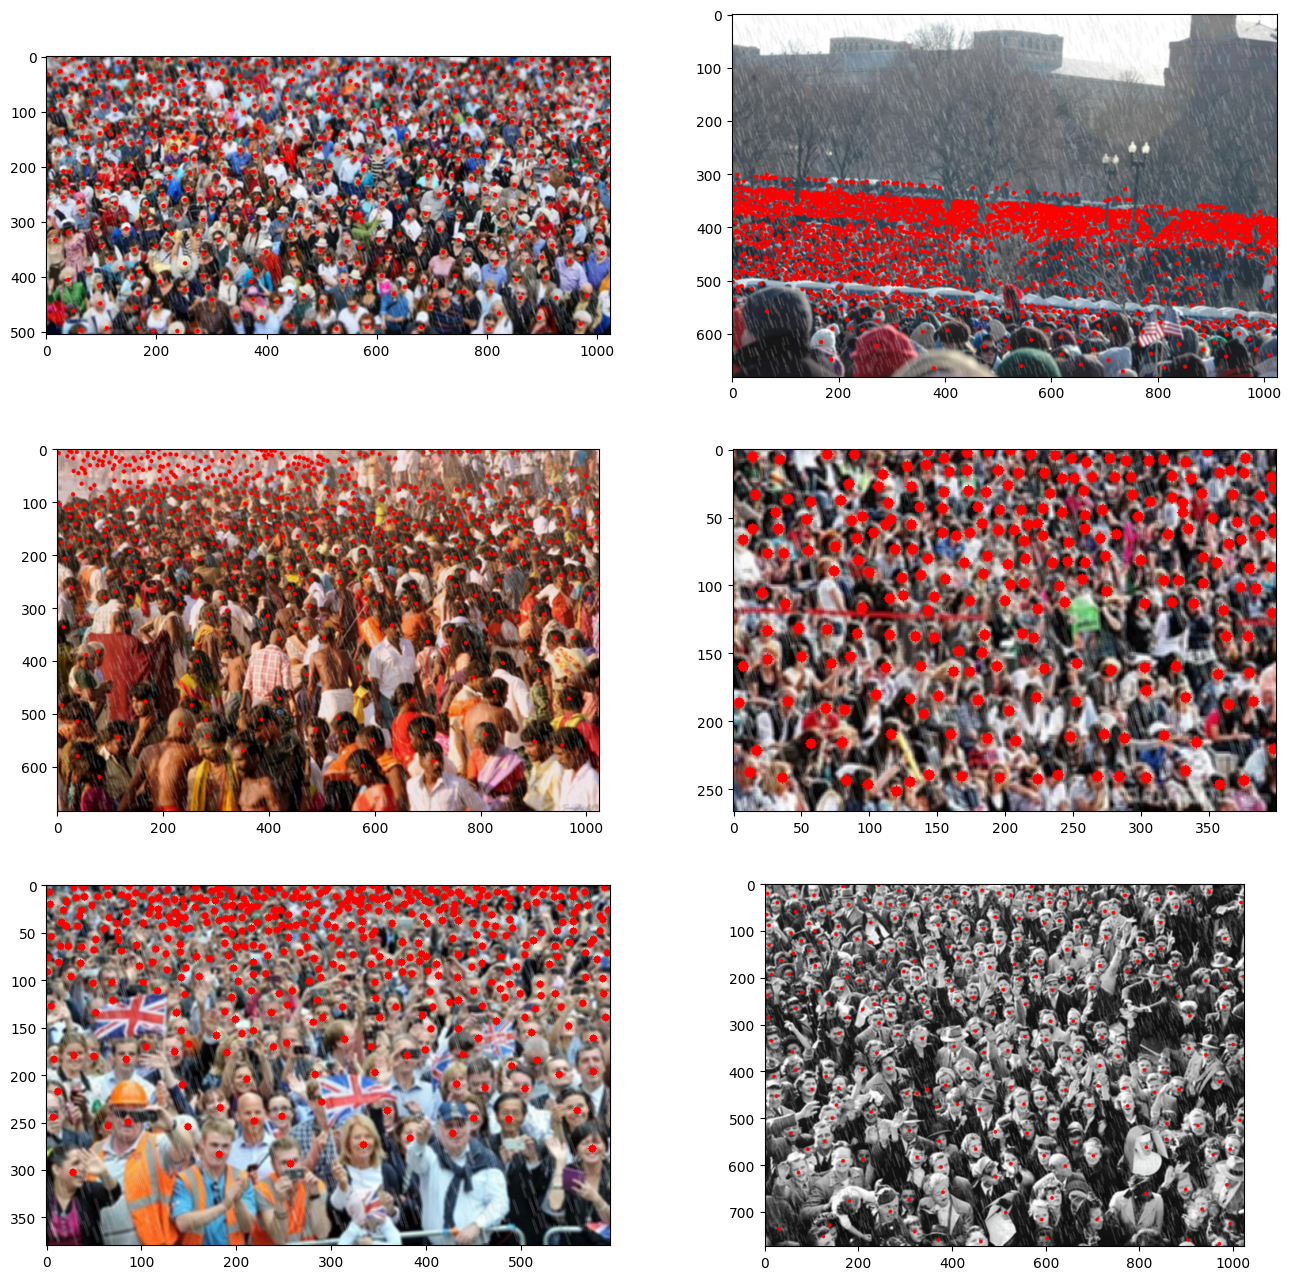

In [21]:
random_indices = np.random.choice(train_dataset.img_labels_df.index, 6)

fig, ax = plt.subplots(3, 2, figsize=(16, 16))

for i, index in enumerate(random_indices):
    sample = train_dataset.img_labels_df.loc[index]
    img = load_image(sample["img_path"])
    gt_labels = sample["gt_labels"]
    ax[i // 2, i % 2].imshow(draw_gt_labels(img, gt_labels))


#### Number of annotations

In [22]:
train_gt_labels = np.array([gt for gt_labels in train_dataset.img_labels_df["gt_labels"] for gt in gt_labels])
val_gt_labels=np.array([gt for gt_labels in val_dataset.img_labels_df["gt_labels"] for gt in gt_labels])
test_gt_labels = np.array([gt for gt_labels in test_dataset.img_labels_df["gt_labels"] for gt in gt_labels])
all_gt_labels = np.concatenate([train_gt_labels,val_gt_labels ,test_gt_labels])

In [23]:
print("Total number of train annotations:", len(train_gt_labels))
print("Total number of test annotations:", len(val_gt_labels))
print("Total number of test annotations:", len(test_gt_labels))
print("Total number of annotations:", len(all_gt_labels))

Total number of train annotations: 162413
Total number of test annotations: 78862
Total number of test annotations: 78862
Total number of annotations: 320137


#### Annotation occlusion levels

In [24]:
train_dataset.img_labels_df["count"].describe()

count     300.000000
mean      541.376667
std       505.162984
min        33.000000
25%       238.750000
50%       378.000000
75%       652.500000
max      3138.000000
Name: count, dtype: float64

In [25]:
test_dataset.img_labels_df["count"].describe()

count     182.000000
mean      433.307692
std       354.438836
min        66.000000
25%       211.000000
50%       307.500000
75%       500.750000
max      2256.000000
Name: count, dtype: float64

In [26]:
all_img_labels_df["count"].describe()

count     664.000000
mean      482.134036
std       431.943455
min        33.000000
25%       214.000000
50%       352.500000
75%       581.750000
max      3138.000000
Name: count, dtype: float64

#### Image resolution statistics

In [27]:
img_resolutions = []
for img_path in all_img_labels_df["img_path"]:
    img = load_image(img_path)
    img_resolutions.append(img.size)
img_resolutions = np.array(img_resolutions)

In [28]:
min_resolution = np.min(img_resolutions, axis=0)
max_resolution = np.max(img_resolutions, axis=0)
mean_resolution = np.mean(img_resolutions, axis=0, dtype=np.int32)
median_resolution = np.median(img_resolutions, axis=0)

print("Minimum image width:", min_resolution[0])
print("Minimum image height:", min_resolution[1])
print("Maximum image width:", max_resolution[0])
print("Maximum image height:", max_resolution[1])
print(f"Mean image resolution: {mean_resolution[0]}x{mean_resolution[1]}")
print(f"Median image resolution: {median_resolution[0]}x{median_resolution[1]}")

Minimum image width: 293
Minimum image height: 182
Maximum image width: 1024
Maximum image height: 1024
Mean image resolution: 866x585
Median image resolution: 1024.0x639.5


#### Distribution of image scene types

## Density map generation

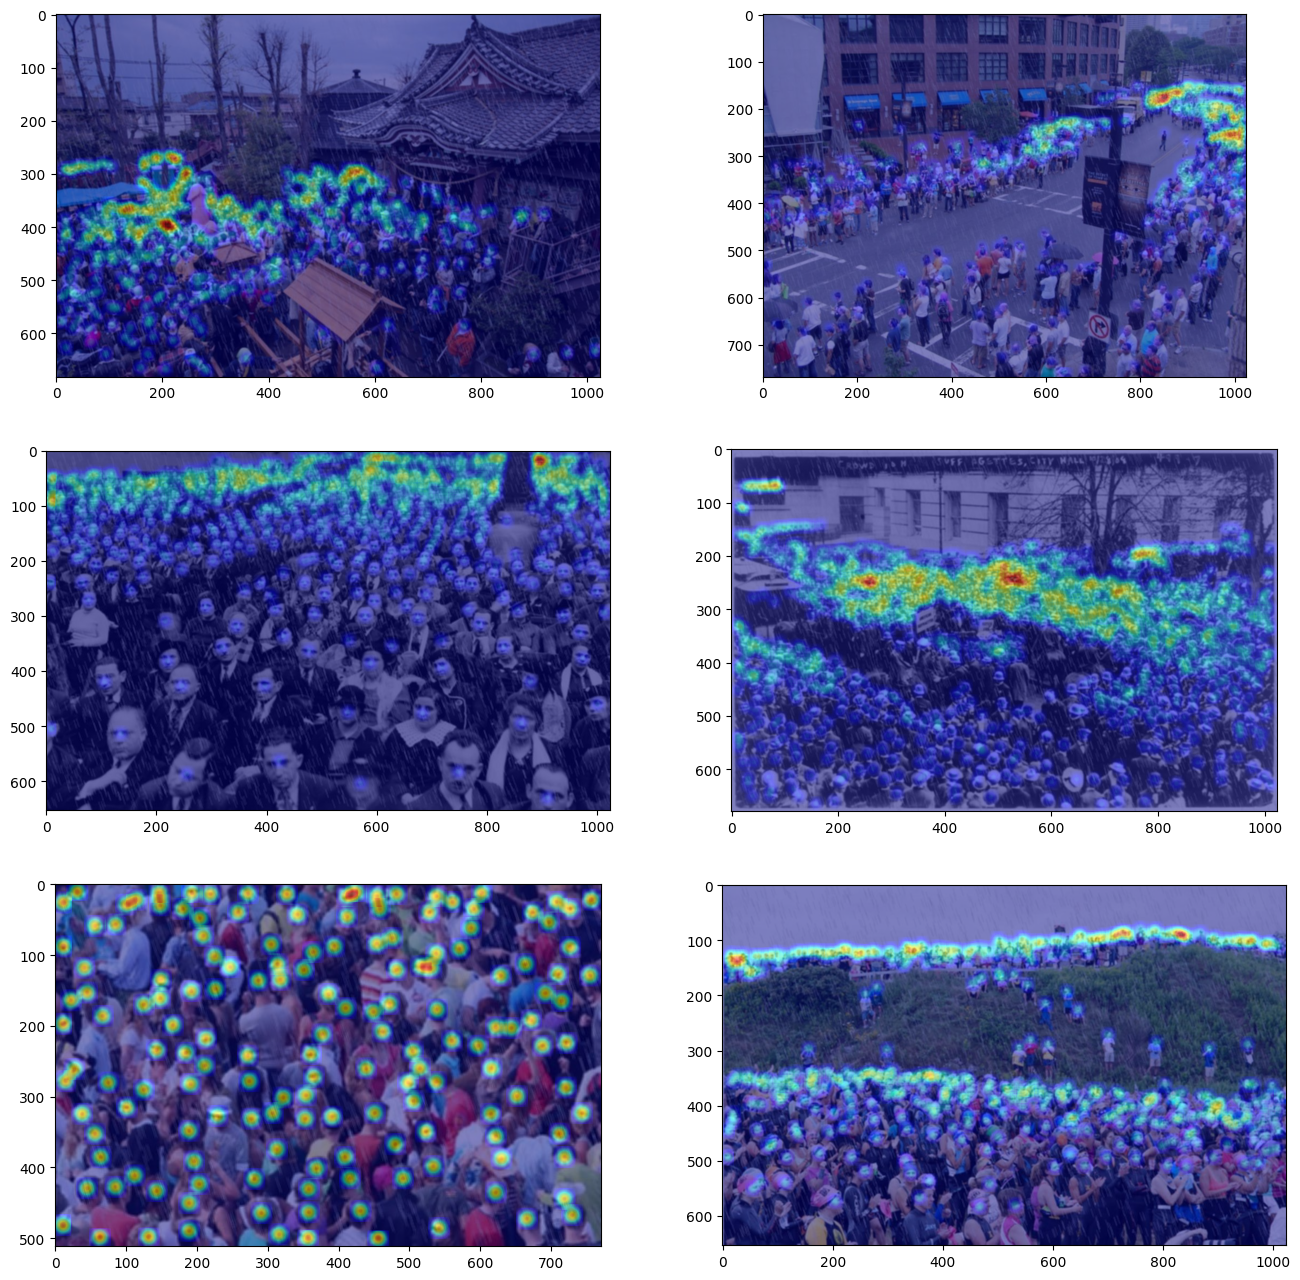

In [29]:
random_indices = np.random.randint(0, len(train_dataset), 6)

fig, ax = plt.subplots(3, 2, figsize=(16, 16))

for i, index in enumerate(random_indices):
    img, density_map = train_dataset[index]
    ax[i // 2, i % 2].imshow(img)
    ax[i // 2, i % 2].imshow(density_map, cmap="jet", alpha=0.5)

## Transforms

In [30]:
def get_train_transform(
    input_h: int = 512,
    input_w: int = 512
) -> Callable[[Image.Image, np.ndarray], Tuple[Tensor, np.ndarray]]:
    def transform(
        img: Image.Image,
        density_map: np.ndarray,
    ) -> Tuple[Tensor, np.ndarray]:
        cropped_img, cropped_density_map = random_crop(img, density_map, input_h=input_h, input_w=input_w)

        aug_result = albu.Compose([
            albu.RandomBrightnessContrast(p=0.4),
            albu.ISONoise(p=0.25),
            albu.HorizontalFlip(p=0.5)
        ])(image=np.array(cropped_img), mask=cropped_density_map)

        cropped_img = Image.fromarray(aug_result["image"])
        cropped_density_map = aug_result["mask"]

        cropped_img = preprocess_transform(cropped_img)

        return cropped_img, cropped_density_map

    return transform



def test_transform(img: Image.Image, density_map: np.ndarray) -> Tuple[Tensor, np.ndarray]:
    img = preprocess_transform(img)
    return img, density_map

## Datamodule

In [31]:
g = torch.Generator()
g.manual_seed(42)
class CrowdDataModule(pl.LightningDataModule):

    def __init__(
        self,
        dataset_root: Path,
        batch_size: int = 8,
        num_workers: int = 8,
        input_size: int = 512,
        min_crowd_size: int = 50,
        density_scale_factor: int = 8,
    ) -> None:
        super().__init__()

        self.dataset_root = dataset_root
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.input_size = input_size
        self.min_crowd_size = min_crowd_size
        self.density_scale_factor = density_scale_factor

    def transfer_batch_to_device(self, batch, device,dataloader_idx):
        batch[0] = batch[0].to(device)
        batch[1] = batch[1].to(device)
        return batch

    def train_dataloader(self) -> DataLoader:
        dataset = JHUCrowdDataset(
            dataset_root=self.dataset_root,
            subset_name="Train",
            min_size=512,
            max_size=1536,
            transform=get_train_transform(input_w=self.input_size, input_h=self.input_size),
            min_crowd_size=self.min_crowd_size,
            scale_factor=self.density_scale_factor
        )

        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            collate_fn=JHUCrowdDataset.collate_fn,
            drop_last=True, #return only complete batch
            shuffle=True,
            worker_init_fn=seed_worker,
            generator=g
        )

    def val_dataloader(self) -> DataLoader:
        dataset = JHUCrowdDataset(
            dataset_root=self.dataset_root,
            subset_name="Val",
            min_size=512,
            max_size=1536,
            transform=test_transform,
            min_crowd_size=self.min_crowd_size,
            scale_factor=self.density_scale_factor
        )

        return DataLoader(
            dataset,
            batch_size=1,
            num_workers=self.num_workers,
            collate_fn=JHUCrowdDataset.collate_fn
        )

    def test_dataloader(self) -> DataLoader:
        dataset = JHUCrowdDataset(
            dataset_root=self.dataset_root,
            subset_name="Test",
            min_size=512,
            max_size=1536,
            transform=test_transform,
            min_crowd_size=self.min_crowd_size,
            scale_factor=self.density_scale_factor
        )

        return DataLoader(
            dataset,
            batch_size=1,
            num_workers=self.num_workers,
            collate_fn=JHUCrowdDataset.collate_fn
        )

## Model

In [32]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

# SSIM Loss
class SSIMLoss(nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.size_average = size_average

    def gaussian_window(self, size, sigma):
        gauss = torch.Tensor([math.exp(-(x - size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(size)])
        return gauss / gauss.sum()

    def create_window(self, window_size, channel):
        _1D_window = self.gaussian_window(window_size, 1.5)
        _2D_window = _1D_window.unsqueeze(1).mm(_1D_window.unsqueeze(0))
        window = _2D_window.unsqueeze(0).unsqueeze(0).expand(channel, 1, window_size, window_size).contiguous()
        return window

    def forward(self, img1, img2):
        (b, c, h, w) = img1.size()
        window = self.create_window(self.window_size, c).to(img1.device)
        mu1 = F.conv2d(img1, window, padding=self.window_size // 2, groups=c)
        mu2 = F.conv2d(img2, window, padding=self.window_size // 2, groups=c)
        sigma1 = F.conv2d(img1 * img1, window, padding=self.window_size // 2, groups=c) - mu1 * mu1
        sigma2 = F.conv2d(img2 * img2, window, padding=self.window_size // 2, groups=c) - mu2 * mu2
        sigma12 = F.conv2d(img1 * img2, window, padding=self.window_size // 2, groups=c) - mu1 * mu2

        C1 = 0.01 ** 2
        C2 = 0.03 ** 2
        ssid = ((2 * sigma12 + C2) * (2 * mu1 * mu2 + C1)) / ((sigma1 + sigma2 + C2) * (mu1 + mu2 + C1))
        return 1 - ssid.mean()

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // ratio, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attention = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(attention))

class CSRNet_Attention(nn.Module):
    def __init__(self):
        super(CSRNet_Attention, self).__init__()
        backbone = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(backbone.features.children())[:22])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1)
        )

        self.ca = ChannelAttention(512)
        self.sa = SpatialAttention()
        self.ssim_loss = SSIMLoss()

        for m in self.backend.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.frontend(x)
        x = self.ca(x) * x  # Apply Channel Attention
        x = self.sa(x) * x  # Apply Spatial Attention
        x = self.backend(x)
        return x

    def compute_loss(self, output, target):
        mse_loss = nn.MSELoss()(output, target)
        ssim_loss = self.ssim_loss(output, target)
        return mse_loss + ssim_loss


## Trainer

In [33]:
import os
import torch
import pytorch_lightning as pl
import torch.nn.functional as F
from torch import Tensor
from torch.optim.lr_scheduler import StepLR
from torchmetrics import MeanAbsoluteError, PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure, MeanSquaredError
from typing import Any, Dict, List

class LitCrowdNet(pl.LightningModule):

    def __init__(self) -> None:
        super().__init__()

        self.model = CSRNet_Attention()

        # Metrics
        self.valid_mae = MeanAbsoluteError()
        self.test_mae = MeanAbsoluteError()
        self.valid_ssim = StructuralSimilarityIndexMeasure()
        self.valid_psnr = PeakSignalNoiseRatio()
        self.test_ssim = StructuralSimilarityIndexMeasure()
        self.test_psnr = PeakSignalNoiseRatio()

        # New MSE metrics
        self.train_mse = MeanSquaredError()
        self.valid_mse = MeanSquaredError()
        self.test_mse = MeanSquaredError()

        # Directory to save outputs
        self.output_dir = "outputs/"
        os.makedirs(self.output_dir, exist_ok=True)

        # Accumulate results to show in the notebook
        self.epoch_metrics = {"validation": [], "test": []}

    def loss(self, pred_dens_map: Tensor, gt_dens_map: Tensor) -> Tensor:
        return F.mse_loss(pred_dens_map, gt_dens_map, reduction="sum") / (torch.sum(gt_dens_map) + 1)

    def forward(self, images: Tensor) -> Tensor:
        return self.model(images)

    def configure_optimizers(self) -> Dict[str, Any]:
        optimizer = torch.optim.AdamW(self.model.parameters(), 5e-6)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": StepLR(optimizer, step_size=5, gamma=0.5)
            },
        }

    def training_step(self, batch: List[Tensor], batch_idx: int) -> Tensor:
        output = self.forward(batch[0])
        loss = self.loss(output, batch[1])
        gt_counts = torch.sum(batch[1].detach().squeeze(1), dim=[1, 2])
        pred_counts = torch.sum(torch.clip(output.detach().squeeze(1), min=0), dim=[1, 2])

        # Log metrics for training
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_mae", self.valid_mae(pred_counts, gt_counts), prog_bar=True)
        self.log("train_ssim", self.valid_ssim(output, batch[1]), prog_bar=True)
        self.log("train_psnr", self.valid_psnr(output, batch[1]), prog_bar=True)
        self.log("train_mse", self.train_mse(output, batch[1]), prog_bar=True)  # Log MSE

        return loss

    def validation_step(self, batch: List[Tensor], batch_idx: int) -> None:
        output = self.forward(batch[0])
        loss = self.loss(output, batch[1])
        gt_counts = torch.sum(batch[1].detach().squeeze(1), dim=[1, 2])
        pred_counts = torch.sum(torch.clip(output.detach().squeeze(1), min=0), dim=[1, 2])

        # Log metrics for validation
        self.log("valid_loss", loss, prog_bar=True)
        self.log("valid_mae", self.valid_mae(pred_counts, gt_counts), prog_bar=True)
        self.log("valid_ssim", self.valid_ssim(output, batch[1]), prog_bar=True)
        self.log("valid_psnr", self.valid_psnr(output, batch[1]), prog_bar=True)
        self.log("valid_mse", self.valid_mse(output, batch[1]), prog_bar=True)  # Log MSE

        # Accumulate metrics for the current epoch
        self.epoch_metrics["validation"].append({
            "epoch": self.current_epoch,
            "loss": loss.item(),
            "mae": self.valid_mae.compute().item(),
            "ssim": self.valid_ssim.compute().item(),
            "psnr": self.valid_psnr.compute().item(),
            "mse": self.valid_mse.compute().item()  # Accumulate MSE
        })

    def test_step(self, batch: List[Tensor], batch_idx: int) -> None:
        output = self.forward(batch[0])
        loss = self.loss(output, batch[1])
        gt_counts = torch.sum(batch[1].detach().squeeze(1), dim=[1, 2])
        pred_counts = torch.sum(torch.clip(output.detach().squeeze(1), min=0), dim=[1, 2])

        # Log metrics for testing
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_mae", self.test_mae(pred_counts, gt_counts), prog_bar=True)
        self.log("test_ssim", self.test_ssim(output, batch[1]), prog_bar=True)
        self.log("test_psnr", self.test_psnr(output, batch[1]), prog_bar=True)
        self.log("test_mse", self.test_mse(output, batch[1]), prog_bar=True)  # Log MSE

        # Accumulate metrics for the current epoch
        self.epoch_metrics["test"].append({
            "epoch": self.current_epoch,
            "loss": loss.item(),
            "mae": self.test_mae.compute().item(),
            "ssim": self.test_ssim.compute().item(),
            "psnr": self.test_psnr.compute().item(),
            "mse": self.test_mse.compute().item()  # Accumulate MSE
        })

    def on_epoch_end(self) -> None:
        # Print accumulated metrics after each epoch
        print(f"\nEpoch {self.current_epoch} Metrics:")
        print("Validation Metrics:")
        for metric in self.epoch_metrics["validation"]:
            print(metric)
        print("Test Metrics:")
        for metric in self.epoch_metrics["test"]:
            print(metric)

        # Clear for next epoch accumulation (optional)
        self.epoch_metrics["validation"].clear()
        self.epoch_metrics["test"].clear()


## Train the model

In [34]:
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import Callback
import os

class MetricsCallback(Callback):
    def __init__(self, save_dir='metrics_plots'):
        super().__init__()
        self.train_losses = []
        self.valid_losses = []
        self.valid_ssim = []
        self.valid_psnr = []
        self.valid_mse = []  # Store MSE values
        self.epochs = []

        # Create directory to save plots
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)
        print(f"Directory created or already exists: {self.save_dir}")

    def on_epoch_end(self, trainer, pl_module):
        # Get metrics from trainer
        metrics = trainer.callback_metrics

        # Log losses and metrics
        train_loss = metrics.get("train_loss", None)
        valid_loss = metrics.get("valid_loss", None)
        valid_ssim = metrics.get("valid_ssim", None)
        valid_psnr = metrics.get("valid_psnr", None)
        valid_mse = metrics.get("valid_mse", None)  # Get MSE

        if train_loss is not None:
            self.train_losses.append(train_loss.item())
        if valid_loss is not None:
            self.valid_losses.append(valid_loss.item())
        if valid_ssim is not None:
            self.valid_ssim.append(valid_ssim.item())
        if valid_psnr is not None:
            self.valid_psnr.append(valid_psnr.item())
        if valid_mse is not None:
            self.valid_mse.append(valid_mse.item())  # Store MSE

        # Save the epoch number
        self.epochs.append(trainer.current_epoch)

        # Plotting the metrics
        self.plot_metrics()

    def plot_metrics(self):
        plt.figure(figsize=(12, 10))

        # Plot Losses
        plt.subplot(2, 2, 1)
        plt.plot(self.epochs, self.train_losses, label='Training Loss', color='blue')
        plt.plot(self.epochs, self.valid_losses, label='Validation Loss', color='orange')
        plt.title('Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()

        # Plot SSIM
        plt.subplot(2, 2, 2)
        plt.plot(self.epochs, self.valid_ssim, label='Validation SSIM', color='green')
        plt.title('Validation SSIM')
        plt.xlabel('Epoch')
        plt.ylabel('SSIM')
        plt.legend()
        plt.grid()

        # Plot PSNR
        plt.subplot(2, 2, 3)
        plt.plot(self.epochs, self.valid_psnr, label='Validation PSNR', color='red')
        plt.title('Validation PSNR')
        plt.xlabel('Epoch')
        plt.ylabel('PSNR')
        plt.legend()
        plt.grid()

        # Plot MSE
        plt.subplot(2, 2, 4)
        plt.plot(self.epochs, self.valid_mse, label='Validation MSE', color='purple')
        plt.title('Validation MSE')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.legend()
        plt.grid()

        # Adjust layout
        plt.tight_layout()

        # Save the plot
        filename = os.path.join(self.save_dir, f'metrics_epoch_{self.epochs[-1]}.png')
        plt.savefig(filename)
        plt.close()  # Close the figure to free memory

        # Debugging: Confirm the file is saved
        if os.path.exists(filename):
            print(f"Saved plot to {filename}")
        else:
            print(f"Failed to save plot to {filename}")


In [35]:
%matplotlib inline


In [36]:
import warnings
warnings.filterwarnings('ignore')
seed_everything(SEED)
dm = CrowdDataModule(DATASET_ROOT)
lit_model = LitCrowdNet()

checkpoint_callback = ModelCheckpoint(
    dirpath=CHECKPOINTS_DIR,
    filename="crowdnet-{epoch:02d}-{valid_mae:.2f}",
    monitor="valid_mae",
    mode="min",
    verbose=True,
    save_top_k=5
)
trainer = pl.Trainer(
    fast_dev_run=False,
    max_epochs=50,
    callbacks=[checkpoint_callback, MetricsCallback()],
    deterministic=True,
    num_sanity_val_steps=0,
    logger=True  # Ensure logs are shown
)

trainer.fit(lit_model, datamodule=dm)

Directory created or already exists: metrics_plots


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Test the model

In [37]:
trainer = pl.Trainer()
trainer.test(lit_model, datamodule=dm)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.11316093802452087    │
│         test_mae          │    121.28433227539062     │
│         test_mse          │   0.005713875405490398    │
│         test_psnr         │     19.83924102783203     │
│         test_ssim         │    0.36034560203552246    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.11316093802452087,
  'test_mae': 121.28433227539062,
  'test_ssim': 0.36034560203552246,
  'test_psnr': 19.83924102783203,
  'test_mse': 0.005713875405490398}]

## Save the model

In [38]:
torch.save(lit_model.model, MODEL_SAVE_PATH)

## Some qualitative results

In [39]:
def count_from_density_map(density_map: np.ndarray) -> int:
    return round(np.sum(np.clip(density_map, a_min=0, a_max=None)))

In [40]:
def predict_density_map(img: Image.Image, model: nn.Module) -> np.ndarray:
    img, resize_ratio = resize_img(img)
    img_input = preprocess_transform(img).unsqueeze(dim=0)
    density_map = model(img_input).detach().cpu().numpy()[0][0]#to exctract the first Image in batch
    return density_map

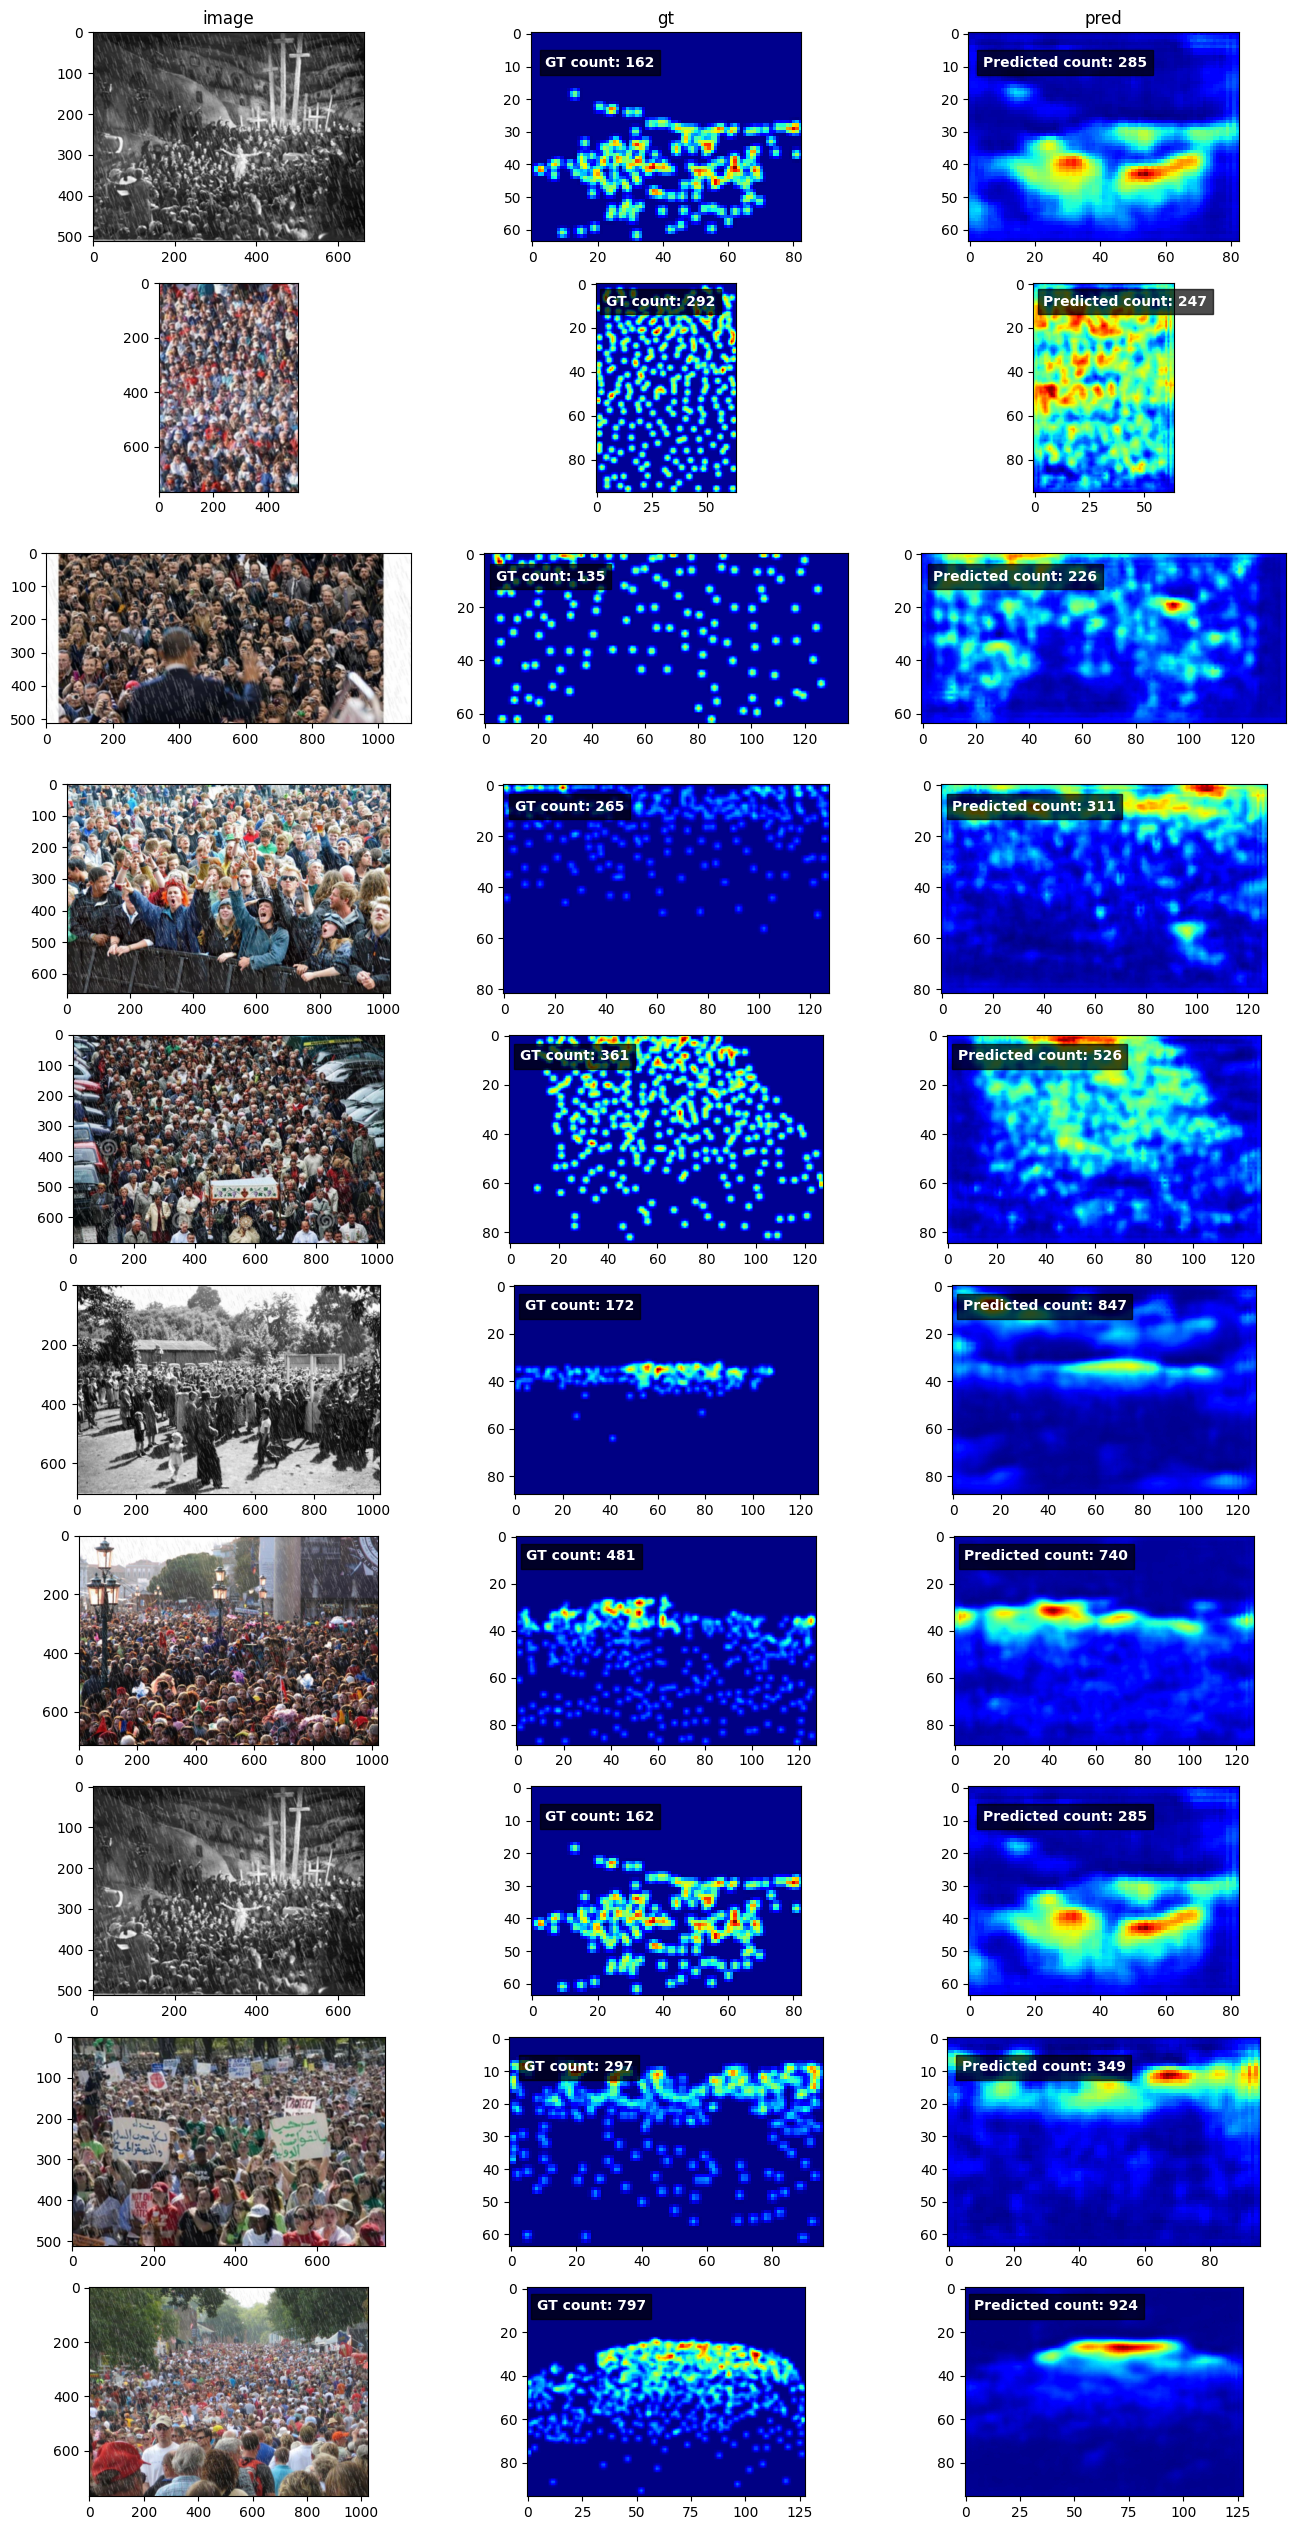

In [41]:
random_indices = np.random.randint(0, len(test_dataset), 10)

fig, axes = plt.subplots(10, 3, figsize=(16, 32))

column_names = ["image", "gt", "pred"]
for ax, col in zip(axes[0], column_names):
    ax.set_title(col)

for i, index in enumerate(random_indices):
    img, density_map = test_dataset[index]

    gt_count = count_from_density_map(density_map)
    density_map = scale_density_map(density_map, 8)

    pred_density_map = predict_density_map(img, lit_model)
    pred_count = count_from_density_map(pred_density_map)

    axes[i, 0].imshow(img)
    axes[i, 1].imshow(density_map, cmap="jet")
    axes[i, 2].imshow(pred_density_map, cmap="jet")

    axes[i, 1].text(
        x=4,
        y=10,
        s=f"GT count: {gt_count}",
        bbox={"facecolor": "black", "alpha": 0.7, "pad": 4},
        c="white",
        weight="bold"
    )

    axes[i, 2].text(
        x=4,
        y=10,
        s=f"Predicted count: {pred_count}",
        bbox={"facecolor": "black", "alpha": 0.7, "pad": 4},
        c="white",
        weight="bold"
    )